In [1]:
#!python -m pip install traitlets==4.3.3 --force-reinstall
#!pip install pywin32==228
#!pip install tiktoken
#installing past numpy version
#!pip install gensim
#!pip install numpy==1.21.6
#!pip install matplotlib
#pip install apache_beam mwparserfromhell



import torch
import tiktoken
import torch
import torch.nn as nn
import torch.nn.functional as F
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors
import sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)

print(torch.cuda.is_available())

2.1.0+cu121
True


In [2]:
def get_batch(data, seq_len, i):
    """Get a batch of data
    Parameters
    ----------
    data : torch.tensor
        The data to get the batch from
    seq_len : int
        The length of the sequence
    i : int
        The batch index
    Returns
    -------
    torch.tensor
        The input sequence
    torch.tensor
        The target sequence
    """
    seq_len = min(seq_len, len(data) - 1 - i)
    inputs = data[i: i + seq_len]
    targets = data[i + 1: i + 1 + seq_len].reshape(-1)
    return inputs, targets

def get_random_batch(split_type='train', block_size=8, batch_size = 4):
    """Get a random batch of data
    Parameters
    ----------
    split_type : str, optional
        The split to get the batch from, by default 'train'
    block_size : int, optional
        The size of the block (quantity of words per example in the batch), by default 8
    batch_size : int, optional
        The batch size (quantity of examples in the batch), by default 4
    Returns
    -------
    torch.tensor
        The input sequence of size (batch_size, block_size)
    torch.tensor
        The target sequence of size (batch_size, block_size)
    """
    data = train_data if split_type == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    x, y = x.to(device), y.to(device)

    return x, y



# TEXT IMPORT (can be changed later on)

In [3]:
#!pip install datasets
from datasets import load_dataset
dataset = load_dataset("wikipedia", "20220301.simple")
print(sys.getsizeof(dataset), "bytes")

/home/alvaro/anaconda3/envs/torch_cuda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


208 bytes


In [4]:
#with open('./data/don_quixote.txt', "r", encoding = 'utf-8') as f:
#    text = f.read()
#
#text= text.replace('\n', ' ').replace('  ', ' ')[121506:]
##text= text.replace(', ', ' , ').replace(': ', ' : ').replace('. ', ' . ').replace('; ', ' ; ').replace('? ', ' ? ').replace('! ', ' ! ')
##text = re.sub(r'(\W|\d)', r' \1 ', text)
#text = text.lower()
#print(text[:1000])


In [5]:
#joing all train text into a single string
text = " ".join(dataset['train']['text'])

print(text[120000:120200])
print(sys.getsizeof(text)/1000000, 'MB')



colleges and universities, such as abstract algebra, linear algebra, and universal algebra. This includes how to use a matrix to solve many linear equations at once. Abstract algebra is the study of t
862.780912 MB


In [6]:
#seeing the different topics in the dataset
import random
random.seed(600)
lower_bound = random.randint(0, len(dataset['train'])-20000)
upper_bound = lower_bound + 20000

print('SAMPLE OF WIKIPEDIA TOPICS IN DATASET:')
for i in range(lower_bound, upper_bound, 2000):
    print(dataset['train']['title'][i])

text = "\n".join(dataset['train']['text'][lower_bound:upper_bound])
print(text[0:1000])
print(sys.getsizeof(text)/1000000, 'MB')


SAMPLE OF WIKIPEDIA TOPICS IN DATASET:
Little Cornard
Adrian Fenty
Da Nang International Airport
2014 Commonwealth Games
Autauga County, Alabama
Notre-Dame-d'Auteuil
Memorial Van Damme
Hypertext
Alfred Hermann Fried
Ruddigore
Little Cornard is a village and civil parish in Babergh, Suffolk, England. In 2001, there were 305 people living in Little Cornard.

References

Other websites

 

Civil parishes in Suffolk
Villages in Suffolk
Settlements in Babergh
The Worldwatch Institute is an environmental organization based in Washington, D.C.  It helps to tell people who make policy and the public about the world economy and the environment. 

Worldwatch Institute publications include The State of the World report, which is about urgent global environmental problems and new ideas for fixing them.

History
 1974—The institute was founded by Lester Brown.
 1975—The first Worldwatch Paper was published.
 1984—First State of the World published.
 1988—World Watch Magazine was launched.
 1992—Vit

In [7]:
import re

def split_into_words_special_chars_and_spaces(text):
    return re.findall('\w+|\S|\s', text)

text_separated = split_into_words_special_chars_and_spaces(text)
print(text_separated[:100])


['Little', ' ', 'Cornard', ' ', 'is', ' ', 'a', ' ', 'village', ' ', 'and', ' ', 'civil', ' ', 'parish', ' ', 'in', ' ', 'Babergh', ',', ' ', 'Suffolk', ',', ' ', 'England', '.', ' ', 'In', ' ', '2001', ',', ' ', 'there', ' ', 'were', ' ', '305', ' ', 'people', ' ', 'living', ' ', 'in', ' ', 'Little', ' ', 'Cornard', '.', '\n', '\n', 'References', '\n', '\n', 'Other', ' ', 'websites', '\n', '\n', ' ', '\n', '\n', 'Civil', ' ', 'parishes', ' ', 'in', ' ', 'Suffolk', '\n', 'Villages', ' ', 'in', ' ', 'Suffolk', '\n', 'Settlements', ' ', 'in', ' ', 'Babergh', '\n', 'The', ' ', 'Worldwatch', ' ', 'Institute', ' ', 'is', ' ', 'an', ' ', 'environmental', ' ', 'organization', ' ', 'based', ' ', 'in', ' ', 'Washington']


In [8]:
vocabulary = list(set(text_separated))
print(vocabulary[0:100])
print("VOC LENGTH: ", len(vocabulary))

#make tokenization separate numbers and special characters

['Dunvegan', 'Arafura', 'Oceanography', 'Trombones', 'Nucuray', 'Teza', 'rolling', 'Dunns', 'rudiments', 'Teacapan', 'syllabi', 'Unfinished', 'Lockhart', 'Upstate', 'Thermedics', 'Shenzi', '淀川', 'MacArthur', 'Glomerulonephritis', 'Technikmuseum', 'Burrton', 'Guadalope', 'Artur', 'LINDL', 'mugs', 'Musik', 'Ornella', 'Kampfgruppen', 'Tekkyeh', 'Shel', 'buds', 'Serial', '12S10', 'noctivagans', 'Getcha', 'Merkava', 'Bernadette', 'RTL', 'Chacun', 'Pemuda', 'Whittemore', 'Sigalet', 'Tāleqān', 'bythose', 'Labrie', 'SIT', 'Olesz', 'ℜ', 'Waterpark', 'Brookneal', 'Rudman', 'mlha', 'Santanachelys', 'Cholula', '420mm', 'pet', 'EFF', 'kuma', 'DMG', 'countess', 'thyroiditis', 'HaLeom', 'Directing', 'Abridged', 'Sebastopol', 'Amherst', 'Eukaryotic', 'Cadrans', 'Ruprecht', 'Musburger', 'allegretto', 'Ogham', 'PSI', 'Nakamachi', 'Pacius', 'Bocotora', 'Vincelottes', 'Rupee', 'Bergsmannijoki', 'IslandDead', 'Lego', 'guys', 'worldview', 'Aul', 'Rolf', 'Arnošt', 'Gorgosaurus', 'Rōnin', 'Nonetheless', 'Manc

In [9]:

words_vocab_size = len(vocabulary)
print('Unique words: ', words_vocab_size)


Unique words:  171840


# TRAINING DATA PREPARATION

## NORMAL TOKENIZATION

In [10]:
# For now, we will be using a basic encoding using only individual characters

stoi = { ch:i for i,ch in enumerate(vocabulary) }
itos = { i:ch for i,ch in enumerate(vocabulary) }

def encode(text_string):
    sep_text =split_into_words_special_chars_and_spaces(text_string)
    return [stoi[i] for i in sep_text]

def decode(encoded_text_list):
    decoded_text = [itos[i] for i in encoded_text_list]
    return ''.join(decoded_text)


print(encode(text[0:199]))
print(decode(encode(text[0:199])))




[153024, 80822, 49433, 80822, 89083, 80822, 147767, 80822, 44959, 80822, 55760, 80822, 28730, 80822, 153241, 80822, 9798, 80822, 7698, 74561, 80822, 102124, 74561, 80822, 116702, 146378, 80822, 152591, 80822, 90579, 74561, 80822, 162098, 80822, 48358, 80822, 94271, 80822, 109506, 80822, 33259, 80822, 9798, 80822, 153024, 80822, 49433, 146378, 154847, 154847, 35768, 154847, 154847, 94985, 80822, 159783, 154847, 154847, 80822, 154847, 154847, 26818, 80822, 101577, 80822, 9798, 80822, 102124, 154847, 44724, 80822]
Little Cornard is a village and civil parish in Babergh, Suffolk, England. In 2001, there were 305 people living in Little Cornard.

References

Other websites

 

Civil parishes in Suffolk
Villages 


## (NOT WORKING YET) TOKENIZATION: Using TikToken For Tokenization (can be changed later on to other like SentencePiece)
Tiktoken does tokenization per word and special character.

In [14]:
enc = tiktoken.get_encoding('gpt2')

tokenized_text = enc.encode(text)
print(len(tokenized_text))

print(len(text.split(' ')))

token_voc_size = len(list(set(tokenized_text)))
print('UNIQUE TOKENS: ',token_voc_size )

53639987
33009438
UNIQUE TOKENS:  49291


In [15]:
data = torch.tensor(tokenized_text, dtype=torch.long)

print('Encoded text: ', tokenized_text[:100])
print('Decoded text: ', enc.decode(tokenized_text[:100]))

Encoded text:  [16784, 318, 262, 5544, 1227, 286, 262, 614, 287, 262, 18322, 290, 8547, 22618, 50215, 11, 290, 2058, 1022, 2805, 290, 1737, 13, 632, 318, 530, 286, 1440, 1933, 284, 423, 1542, 1528, 13, 198, 198, 16784, 1464, 6140, 319, 262, 976, 1110, 286, 1285, 355, 2901, 11, 290, 36527, 11, 3269, 287, 16470, 812, 13, 3035, 1464, 5645, 319, 262, 976, 1110, 286, 262, 1285, 355, 3426, 13, 198, 198, 16784, 338, 12734, 389, 262, 15335, 2631, 64, 290, 40355, 13, 6363, 4082, 6440, 318, 262, 15291, 13, 383, 3616, 286, 262, 15291, 318, 24211, 13, 198, 198, 464]
Decoded text:  April is the fourth month of the year in the Julian and Gregorian calendars, and comes between March and May. It is one of four months to have 30 days.

April always begins on the same day of week as July, and additionally, January in leap years. April always ends on the same day of the week as December.

April's flowers are the Sweet Pea and Daisy. Its birthstone is the diamond. The meaning of the diamond is innocence.


## EMBEDDING: Implementing Word2Vec Embeddings (can be changed later on like GloVe)
In this case, the embedding imported transforms each word and special character into a 300-dim vector, meaning that a sentence of 8 words will be transformed into a [8, 300] tensor.

In [11]:
emb_model = KeyedVectors.load_word2vec_format('./embedding_models/GoogleNews-vectors-negative300.bin', binary=True)

In [12]:
#using the model to get embeddings of our text
import numpy as np

embeddings = []
for word in vocabulary:
    try:
        embeddings.append(emb_model[word])
    except:
        # Add a random vector for words not found in the pre-trained model
        # we can experiment with different initializations like zeros, normal distribution, glorot, He, etc.
        embeddings.append(np.random.normal(scale=0.6, size=(300,)))

embeddings = np.array(embeddings)
print(embeddings.shape)

print("Unique words (vocab size): ", len(vocabulary))

(171840, 300)
Unique words (vocab size):  171840


In [13]:
#printing an example of the embedding
idx = random.randint(0, words_vocab_size)
print('Word: ', vocabulary[idx])
print('Embedding: ', embeddings[idx])

Word:  Nagatomo
Embedding:  [-2.14843750e-02  2.12890625e-01  1.96289062e-01 -2.74658203e-02
  1.56250000e-01 -6.09375000e-01 -1.15234375e-01 -1.85546875e-01
  2.94921875e-01  8.20312500e-02  2.68554688e-02  9.71679688e-02
  2.05078125e-02 -4.29687500e-02 -1.72851562e-01  8.39843750e-02
 -2.98828125e-01  1.46484375e-01  1.81640625e-01  8.64257812e-02
  1.41601562e-01 -4.29687500e-02  2.31445312e-01  2.81982422e-02
  2.26562500e-01 -1.35742188e-01 -1.52343750e-01 -3.45703125e-01
  1.31835938e-01  1.66992188e-01  8.74023438e-02  1.19018555e-02
  3.06396484e-02  4.07714844e-02 -1.26953125e-01 -2.08984375e-01
 -8.25195312e-02 -5.61523438e-02 -1.64794922e-02  4.05273438e-02
 -6.39648438e-02 -4.56542969e-02  1.31835938e-01  2.45117188e-01
  2.12890625e-01 -1.28784180e-02  4.29687500e-01  1.63085938e-01
  8.30078125e-02 -1.28906250e-01  4.69207764e-04  1.14746094e-01
  1.36718750e-01  4.68750000e-02 -2.10937500e-01  3.04687500e-01
  1.04980469e-01  1.42578125e-01 -2.42187500e-01 -4.06250000e-

Reducing dimensionality...


Done!


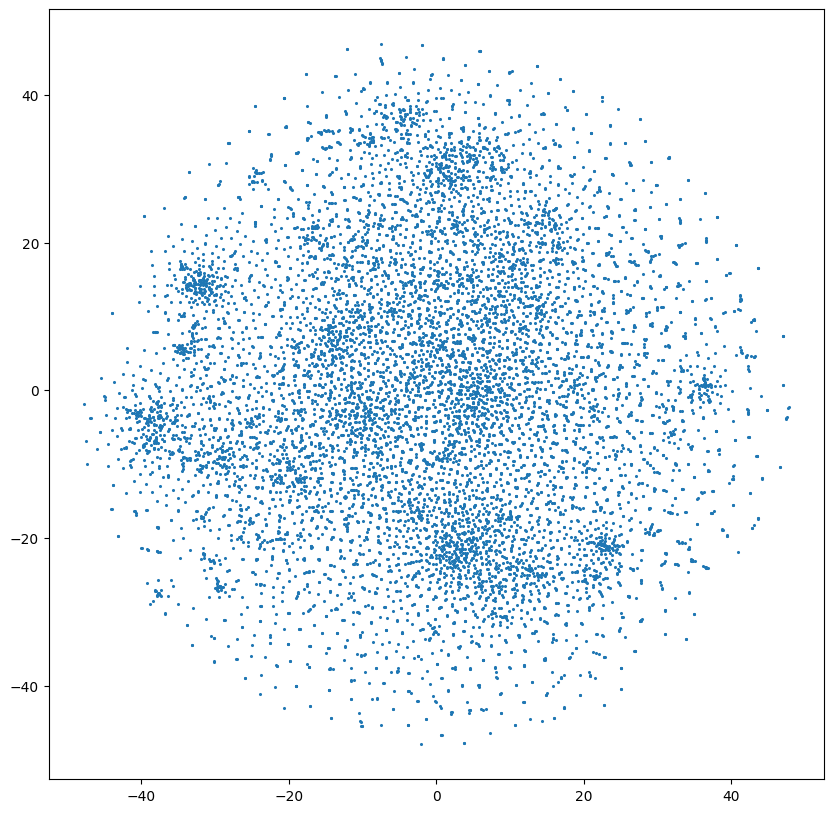

In [14]:
#using TSNE to reduce the dimensionality of the embeddings for just some words
print('Reducing dimensionality...')
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings[:10000])
print('Done!')

#plotting the embeddings using matplotlib
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1.5)
plt.show()
del embeddings_2d
del tsne

## TRAINING OWN EMBEDDING

In [80]:
import numpy as np
import pandas as pd
import os
import re
import time

from gensim.models import Word2Vec


In [81]:
sentences = []
start = 0
for i, word in enumerate(text_separated):
    if word in [".", '?', '!']:
        sentences.append(text_separated[start : i+1])
        start = i+1
del start

In [82]:
#train_emb_sentences =  [item for item in sentences for _ in range(2)]

emb_model = Word2Vec(sentences=sentences,
                 min_count=1,
                 sg=1,
                 vector_size =256,
                 workers=8)


In [91]:
emb_model.wv.most_similar('threat')

[('contracts', 0.9070072174072266),
 ('offense', 0.904539167881012),
 ('runaway', 0.904087483882904),
 ('benefit', 0.9038001298904419),
 ('breach', 0.9032521843910217),
 ('aggression', 0.9015160799026489),
 ('permit', 0.9015098810195923),
 ('sovereignty', 0.9005150198936462),
 ('recognizing', 0.8957819938659668),
 ('sovereign', 0.8951665163040161)]

## EMBEDDING WORD BY WORD TESTING

In [15]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_random_batch(split, block_size = block_size, batch_size= batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear( n_embed, head_size, bias=False)
        self.query = nn.Linear( n_embed, head_size, bias=False)
        self.value = nn.Linear( n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,  n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        proj = self.proj(out)
        out = self.dropout(proj)
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self,  n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear( n_embed, 4 *  n_embed),
            nn.ReLU(),
            nn.Linear(4 *  n_embed,  n_embed),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self,  n_embed, n_head):
        #  n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size =  n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward( n_embed)
        self.ln1 = nn.LayerNorm( n_embed)
        self.ln2 = nn.LayerNorm( n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class BigramModel(nn.Module):
    def __init__(self, char_vocab_size, n_embed=300, weights=None):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding.from_pretrained(weights, freeze=True)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(*[Transformer(n_embed, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed) # final layer norm
        self.lm_head = nn.Linear(n_embed, char_vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,char_vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [16]:
# hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running on' , device)
# deleting model from memory
if 'm' in locals():
    del m

torch.cuda.empty_cache()


data  = torch.tensor(encode(text), dtype=torch.long)
batch_size = 20 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
eval_iters = 20
n_embed = 300
n_head = 15
n_layer = 32
dropout = 0.4
vocab_size = len(vocabulary)
epoch_list = []
train_loss = []
val_loss = []
# n_embed / n_head must equal batch_size

#defining model
import os.path
if os.path.exists('./model_backup.pth'):
    model = torch.load('./model_backup.pth')
else:
    model = BigramModel(vocab_size, weights=torch.tensor(embeddings, dtype=torch.float))
m = model.to(device)
print('Model Defined')

# Setting the training split to 90%
train_split = int(0.9 * len(data))
train_data = data[:train_split]
val_data = data[train_split:]


print(sum(p.numel() for p in m.parameters())/1e6, 'M total parameters')
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params / 1e6:.2f} M total trainable parameters.')

import time
optimizer = torch.optim.AdamW(m.parameters(), lr =learning_rate)
start_time = time.time()  # Get the current time
for step in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if step % eval_interval == 0 or step == max_iters - 1:
        end_time = time.time()  # Get the current time
        avg_time_per_step = (end_time - start_time) / eval_interval if step != 0 else (end_time - start_time)
        start_time = end_time  # Reset the start time for the next interval

        epoch_list.append(step)
        losses = estimate_loss()
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}. Avg time per step {avg_time_per_step:.2f} seconds")
        torch.save(m, 'model_backup.pth')

    x_train, y_train = get_random_batch('train', block_size = block_size, batch_size= batch_size)
    logits, loss = m(x_train, y_train)
    optimizer.zero_grad(set_to_none = 1)
    loss.backward()
    optimizer.step()

import matplotlib.pyplot as plt
plt.figure()
plt.plot(epoch_list, train_loss)
plt.plot(epoch_list, val_loss)
plt.show()

print(decode(m.generate(idx =torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=100)[0].tolist()))

Running on cuda
Model Defined
137.95164 M total parameters
86.40 M total trainable parameters.
step 0: train loss 12.2362, val loss 12.2313. Avg time per step 0.00 seconds


In [15]:
300//16

18

In [110]:
# Encode the input phrase
input_phrase = torch.tensor(encode('United States'), dtype=torch.long).unsqueeze(0).to(device)

# Generate prediction
output = m.generate(idx=input_phrase, max_new_tokens=35)

# Check the dimension of the output
if len(output.shape) > 1:
    # If the output is at least 2-dimensional, access the first index
    output = output[0]

# Decode the output
print(decode(output.tolist()))

United States the company-Bagge ⊙ Poland Illinois, by Jura State on a studio, has Thuringia a same'


In [111]:
torch.save(m, 'model.pth')

In [ ]:
model = Word2Vec(text) #traain using the direct translations from tokenized to list of strings!
model

#NEED TO MAKE EMBEDDINGS FOR EACH TOKENIZATION TRANSLATION (ORIGIN OF ERROR ABOVE)
# 1. separate original string text into sentences
# 2. for each sentence, run tokenization
# 3. for each tokenized sentence, do the same as in print([emb_model[str] for str in [enc.decode([i]) for i in encoded]]) above
# 4. With the list of sentences as [[], [], []], feed into Word2Vec(sentences)
# 5. Save model
# 6. Load as done before in the code and retest cell above

# https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

#OPTION 2: FINETUNE MODEL DOWNLOADED